In [ ]:
!pip install librosa
!pip install tensorflow_io

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.3/214.3 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 58.8 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 58.9 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 40.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 32.5 MB/s eta 0:00:0000:0100:01
  Created wheel for audioread: filename=audioread-3.0.0-py3-none-any.whl size=23702 sha256=5392bfd0f38d441465a729c9f153f949f4f1f08c4a8f7e91b3fd9d5cb33ea612
  Stored in directory: /root/.cache/pip/wheels/e4/76/a4/cfb55573167a1f5bde7d7a348e95e509c64b2c3e8f921932c3
Successfully built audioread
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.0/25.0 MB 36.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 56.4 MB/s eta 0:

In [26]:
########################################################################
# import python-library
########################################################################
# from import
import keras.models
import tensorflow as tf
from keras import backend as K
from keras import layers
from keras.models import Model
from keras.initializers import orthogonal
from keras import activations
from tensorflow.keras.models import Sequential
# import kapre
# from kapre.augmentation import SpecAugment
# from kapre.composed import get_melspectrogram_layer
import tensorflow_io as tfio
from librosa.display import specshow
import numpy as np

In [27]:
# melgram = get_melspectrogram_layer(input_shape=input_shape,
#                                                   n_fft=1024,
#                                                   return_decibel=True,
#                                                   n_mels=128,
#                                                   hop_length=429,
#                                                   input_data_format='channels_last',
#                                                   output_data_format='channels_last')

In [28]:
def file_list_to_data(file_list,
                      msg="calc...",
                      n_mels=64,
                      n_frames=5,
                      n_hop_frames=1,
                      n_fft=1024,
                      hop_length=512,
                      power=2.0):
    """
    convert the file_list to a vector array.
    file_to_vector_array() is iterated, and the output vector array is concatenated.

    file_list : list [ str ]
        .wav filename list of dataset
    msg : str ( default = "calc..." )
        description for tqdm.
        this parameter will be input into "desc" param at tqdm.

    return : numpy.array( numpy.array( float ) )
        data for training (this function is not used for test.)
        * dataset.shape = (number of feature vectors, dimensions of feature vectors)
    """

    # iterate file_to_vector_array()
    for idx in tqdm(range(len(file_list)), desc=msg):
        vectors = com.file_to_vectors(file_list[idx],
                                                n_mels=n_mels,
                                                n_frames=n_frames,
                                                n_fft=n_fft,
                                                hop_length=hop_length,
                                                power=power)
        # vectors_masked = com.spec_augment(vectors)
        if idx == 0:
            data = np.zeros((len(file_list), vectors.shape[0], vectors.shape[1]), float)
            # data_masked = np.zeros((len(file_list), vectors_masked.shape[1], vectors_masked.shape[0]), float)
        data[idx, :, :] = vectors
        data[idx,:,:] = librosa.power_to_db(data[idx,:,:])
        # data_masked[idx, :, :] = vectors_masked.T
    return data


In [50]:
def file_to_vectors(file_name,
                    n_mels=128,
                    n_fft=1024,
                    hop_length=431,
                    power=2.0):
    """
    convert file_name to a vector array.

    file_name : str
        target .wav file

    return : numpy.array( numpy.array( float ) )
        vector array
        * dataset.shape = (dataset_size, feature_vector_length)
    """

    # generate melspectrogram using librosa
    file_contents = tf.io.read_file(file_name)
    y, sr = tf.audio.decode_wav(file_contents, desired_channels=1)
    y = tf.squeeze(y, axis=[-1])
    spectrogram = tfio.audio.spectrogram(y, nfft=n_fft, window=n_fft, stride=hop_length)
    mel_spectrogram = tfio.audio.melscale(spectrogram, sr, mels=n_mels, fmin=0, fmax=11025, name=None)
    dbscale_mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=120)
    masked_mel_spectrogram = tfio.audio.freq_mask(dbscale_mel_spectrogram, param=30)
    masked_mel_spectrogram = tfio.audio.freq_mask(masked_mel_spectrogram, param=20)
    masked_mel_spectrogram = tf.expand_dims(masked_mel_spectrogram, axis=2)
    # convert melspectrogram to log mel energies
    return masked_mel_spectrogram

In [51]:
class RandomFrequencyMasking(tf.keras.layers.Layer):
    def __init__(self, num_mask=2, freq_masking_max_percentage=0.125, **kwargs):
        super(RandomFrequencyMasking, self).__init__(**kwargs)
        self.num_mask = num_mask
        self.freq_masking_max_percentage = freq_masking_max_percentage
    
    
    def spec_augment_freq(self, spec):
        spec = spec.copy()
        spec[27:44, :] = -100
        return spec

    def spec_augment(self, spec):
        spec = spec.copy()
        for i in range(self.num_mask):
            all_frames_num = spec.shape[0]
            freq_percentage = self.freq_masking_max_percentage
            num_frames_to_mask = int(freq_percentage * all_frames_num)
            t0 = np.random.uniform(low=0.0, high=(all_frames_num) - num_frames_to_mask)
            t0 = int(t0)
            spec[t0:t0 + num_frames_to_mask, :] = 0
        return spec

    def call(self, data, training=None):
        data = np.squeeze(data, axis=3)
        if not training:
            for idx in range(len(data)):
                vectors_masked = self.spec_augment_freq(data[idx,:,:])
                if idx == 0:
                    data_masked = np.zeros((len(data), vectors_masked.shape[0], vectors_masked.shape[1]), float)
                data_masked[idx, :, :] = vectors_masked
            data_masked = tf.convert_to_tensor(data_masked.reshape(len(data), data_masked.shape[1], data_masked.shape[2], 1), dtype=tf.float32)
            return data_masked
        
        for idx in range(len(data)):
            vectors_masked = self.spec_augment(data[idx,:,:])
            if idx == 0:
                data_masked = np.zeros((len(data), vectors_masked.shape[0], vectors_masked.shape[1]), float)
            data_masked[idx, :, :] = vectors_masked
        data_masked = tf.convert_to_tensor(data_masked.reshape(len(data), data_masked.shape[1], data_masked.shape[2], 1), dtype=tf.float32)
        return data_masked

In [52]:
import common as com
import os
import sys
mode = True
from tqdm import tqdm
param = com.yaml_load()
import tensorflow as tf
import matplotlib.pyplot as plt

# make output directory
os.makedirs(param["model_directory"], exist_ok=True)

# load base_directory list
dirs = com.select_dirs(param=param, mode=mode)
idx = 0
# target_dir = "/content/drive/MyDrive/dev_data/car8"
target_dir = "dev_data/car1"
# loop of the base directory
print("\n===========================")
print("[{idx}/{total}] {target_dir}".format(target_dir=target_dir, idx=idx+1, total=len(dirs)))
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)

# set path
machine_type = os.path.split(target_dir)[1]
model_file_path = "{model}/model_{machine_type}.hdf5".format(model=param["model_directory"],
                                                                machine_type=machine_type)

history_img = "{model}/history_{machine_type}.png".format(model=param["model_directory"],
                                                            machine_type=machine_type)
# pickle file for storing anomaly score distribution
score_distr_file_path = "{model}/score_distr_{machine_type}.pkl".format(model=param["model_directory"],
                                                                        machine_type=machine_type)

# generate dataset
print("============== DATASET_GENERATOR ==============")

# get file list for all sections
# all values of y_true are zero in training


pos = tf.data.Dataset.list_files(f"{target_dir}/train/*.wav")
pos = pos.shuffle(buffer_size=10000).repeat(150).map(file_to_vectors).batch(32).prefetch(1)
# filepath = pos.shuffle(buffer_size=10000).map(file_to_vectors).as_numpy_iterator().next()
spectrogram = file_to_vectors(filepath)
print(spectrogram.shape)
# plt.figure(figsize=(30,20))
# plt.imshow(tf.transpose(spectrogram))
# plt.show()
# data = pos.map(file_to_vectors)
# filepath = data.shuffle(buffer_size=10000).as_numpy_iterator().next()
# print(filepath)



2022-10-17 18:48:51,660 - INFO - load_directory <- development



[1/8] dev_data/car3
============== DATASET_GENERATOR ==============
(512, 128, 1)


In [ ]:
import matplotlib.pyplot as plt

(611, 128, 512, 1)
(611, 128, 512)


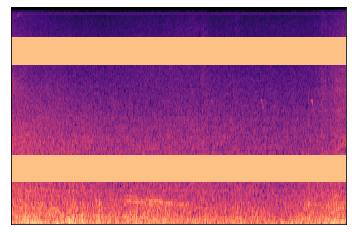

In [75]:
layer = RandomFrequencyMasking()
aug = layer(data, training=True)
# specshow(aug.numpy())
print(aug.shape)
aug = np.squeeze(aug.numpy(), axis=3)
print(aug.shape)
specshow(aug[1])

In [15]:
model = Sequential()
model.add(melgram)
model.add(spec_augment)
model.summary()

NameError: name 'melgram' is not defined

In [32]:
import matplotlib.pyplot as plt

(512, 128)


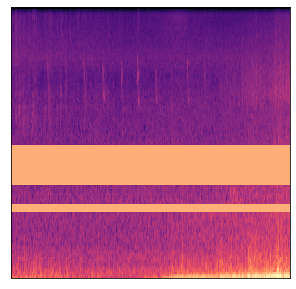

In [33]:
plt.figure(figsize=(5, 5))
dis = model(audio_tensor, training=True).numpy()
dis = dis[0,:,:]
dis = np.squeeze(dis, axis=2)
print(dis.shape)
specshow(dis.T)

(512, 128)


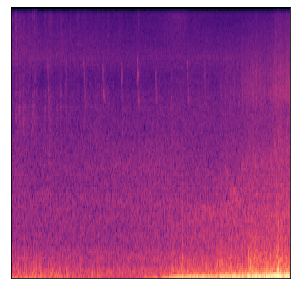

In [34]:
plt.figure(figsize=(5, 5))
dis = model(audio_tensor).numpy()
dis = dis[0,:,:]
dis = np.squeeze(dis, axis=2)
print(dis.shape)
specshow(dis.T)